# Lecture 05 & 06: Pytorch and Supervised Learning

## Main Learning Outcomes
- Understanding pytorch/numpy representation and manipulating of higher-dimensional data.
- A mathematical primer to supervised learning.
- Multi-layer perceptron linear algebra computation.
- Pytorch Autograd.

## Pytorch Tensors
- <font color='DarkGoldenRod'>Storage</font> of tensors (ndarrays) is always linear and contiguous.
- Broadcast: manipulating the <font color='DarkGoldenRod'>stride</font> of the argument tensors, so operations can be done. <br>
Example, for elementwise operations, it makes both arrays of equal size.

In [1]:
# previously in the course....
from math import sqrt
from random import Random

def generat_random_points(N=1000):
 SEED = 5
 random_obj = Random(x=SEED)
 list_x, list_y = [],[]
 for i in range(N):
    list_x.append (random_obj.uniform(a=0, b=1))
    list_y.append (random_obj.uniform(a=0, b=1))
 return list_x, list_y
# Generating Random Points
x_i, y_i = generat_random_points()

def loss_normal(x_p, y_p, x_i, y_i):
    return 1/len(x_i)*sum(sqrt((x_i-x_p)**2+(y_i-y_p)**2) for x_i, y_i in zip(x_i, y_i))

def gradient_loss(x_p, y_p, list_x, list_y, epoches = 100  ):
    H = 0.001
    STEP = 0.1
    x_p,y_p = 5,5
    for _ in range (epoches):
        dl_dx = (loss_normal(x_p+H,y_p,x_i, y_i)-loss_normal(x_p, y_p, x_i, y_i))/H
        dl_dy = (loss_normal(x_p,y_p+H,x_i, y_i)-loss_normal(x_p, y_p, x_i, y_i))/H
        x_p -= dl_dx*STEP
        y_p -= dl_dy*STEP 
    return x_p, y_p



In [2]:
from time import monotonic
data_x, data_y = generat_random_points()
STEP = 0.01
MESH_SIZE = 50
x_mesh = [-1 + i*STEP for i in range(MESH_SIZE)]
y_mesh = [-1 + i*STEP for i in range(MESH_SIZE)]
print(gradient_loss(5,5,data_x,data_y))
# Calculating the time of loss mesh
start_time = monotonic()
z_or_loss_mesh=[ # list of lists, kind of 2d integration
    [gradient_loss(x_curr,y_curr,data_x,data_y) for x_curr in x_mesh] 
    for y_curr in y_mesh]
print(f"Time = {(monotonic() - start_time)*1000:0.2f} Us")

(0.4922786505102261, 0.4916266973358796)
Time = 602703.00 Us


### Problems with using plain vanilla python
- There's no direct way to manipulate higher dimention data.
- It doesn't allow for efficient computation / not stored in a contigious memory
#### We can solve these problems using pytorch, tensorflow, numpy...etc

In [3]:
import torch
data_torch = torch.tensor([data_x,data_y])
print(f"its original shapt{data_torch.shape}")
print(f"shape after transposing {data_torch.t().shape}")


its original shapttorch.Size([2, 1000])
shape after transposing torch.Size([1000, 2])


### Under the hood, how pytorch stores the data in the tensor

using storage() function, pytorch tells us how are they stored, returning the underlying storage <br> in a contigious array


let's see the place and address after and before transposing, we notice that it didn' change <br> How did that magic happen? <br> pytorch seperates the storage and its view, the memory view

In [4]:
print(f"pointer for data torch  {data_torch.untyped_storage().data_ptr()}")
print(f"pointer for data torch after transposing {data_torch.t().untyped_storage().data_ptr()}")

pointer for data torch  4745989201920
pointer for data torch after transposing 4745989201920


### Strides in pytorch
Stride is the jump necessary to go from one element to the next one in the specified dimension dim / in the contigious memeory. A tuple of all strides is returned when no argument is passed in. Otherwise, an integer value is returned as the stride in the particular dimension dim. 


In [5]:
print(data_torch.stride())
# (1000 , 1) means you will jump over 1000 element whenever you take one step in dim 0
# and jump over 1 element to take one step in dim 1
# to make sure
print(data_torch.stride(0))
print(data_torch.stride(1))

(1000, 1)
1000
1


In [6]:
# after transposing
print(data_torch.t().stride())
# (1,1000) means you will jump over 1000 element whenever you take one step in dim 1
# and jump over 1000 element to take one step in dim 0
# to make sure
print(data_torch.t().stride(0))
print(data_torch.t().stride(1))

(1, 1000)
1
1000


In [7]:
# what about strides of 3d array
d_tensor = torch.tensor([[[1,1],[2,2],[3,3],[4,4]]])
print(d_tensor.stride())
# 1 element in dim 0 of length of dim = 8
# 2 elements in dim 1 of length of dim = 2
# 4 elements in dim 3 of length of dim = 1 


(8, 2, 1)


### Transpose to be able to broadcast to 100x1000x2
1000 data points and each data point has 2 features


In [8]:
data_torch = data_torch.t()

### Broadcasting
imagine your data in much higher dimentions, makes no sense? <br> broadcast_to(size * it's an iterable * = (100, 1000, 200)) <br> we then notice that in the created dimention, the stride is zero, meaning that we don't change the original tensor, it's just a fake view of my data <br> that saves us from making the very expensive operation of changing the data in the memory

In [9]:
data_torch = data_torch.broadcast_to(size = (100,1000,2))
print(f" shape after broadcasting{data_torch.shape}")
print(f"strides after broadcasting{data_torch.stride()}")

 shape after broadcastingtorch.Size([100, 1000, 2])
strides after broadcasting(0, 1, 1000)


### To benefit from what we have done, can we make the z-dim mesh faster 
(yaret begad 3ashan el lap hena bymooot TOT) <br> first, make a benchmark to compare, from time import monotonic, it guarantees that the time goes in one direction, instead of increasing and decreasing <br> it returns the time in seconds, multiply by 1000 to return in ms

In [10]:
from time import monotonic

Finding the loss of two arbitary points, 5,5 <br> firstly, pass them as single integers to the normal loss function <br> secondly, use tensors

In [11]:
old_loss = loss_normal(5,5,data_x,data_y)
old_loss

6.38204955626828

In [12]:
# calculate the loss using pytorch way
pnt = torch.tensor([5,5])
data_torch = torch.tensor([data_x,data_y]).t()
res = data_torch - pnt # puting on the linear algebra hat, 
# we are trying to subtract (1 x 2) from (1000 x 2)
# but that's possible because pnt was broadcasted to (1000 x 2) to enable element wise operations
# read broadcasting semantics, https://pytorch.org/docs/stable/notes/broadcasting.html 

# now to get the hypotenuse
res = res**2
res = res.sum(dim = 1)
res = torch.sqrt(res)
res = res.sum(dim = 0) / data_torch.shape[0]
res



tensor(6.3821)

### Lamda syntax & Vectoralization
imagine it as creating a function on one line <br> One line function
<br> functions in python are ??? but also variables, objects

In [15]:
import torch
torch_loss_function = lambda pnt, data: torch.sqrt(((data - pnt)**2).sum(dim = 1)).sum(dim = 0) / data.shape[0]

torch_data = torch.tensor([data_x, data_y]).t()
x_axis = [-1+i*.01 for i in range(MESH_SIZE)]
y_axis = [-1+i*.01 for i in range(MESH_SIZE)]
# it's not the best choice to compare the code execution based on one run only, as there's stochasticity in the process, but this will do for now
start_time_torch = monotonic()
z_axis = [[torch_loss_function(torch.tensor([x_curr,y_curr]), torch_data)for x_curr in data_x]
for y_curr in data_y]
print(f"Time using pytorch = {(monotonic() - start_time_torch )*2000:0.2f} Us")

Time using pytorch = 178814.00 Us


In [ ]:
# Further speed comparison


In [16]:
# from matplotlib.pyplot import figure
# ax = figure(figsize = (20,20))
# loss = ax.add_subplot(1,2,1, projection = "3d")
# loss.contour(data_x,data_y,z_axis, levels = 500)
# loss.view_init(elev = 0)


: 

### Know about acceleration?? 
use gpus instead of cpus 


False

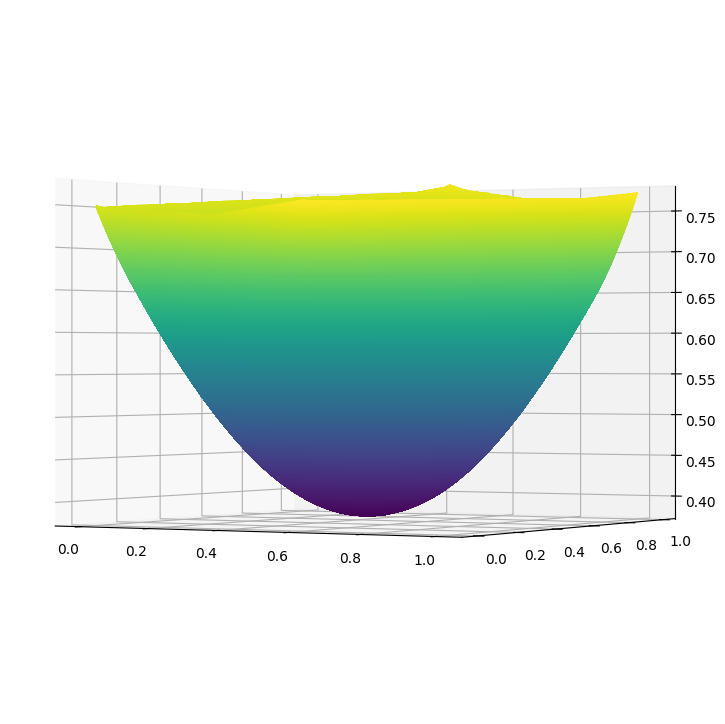

In [ ]:
torch_loss_fn = lambda pnt, data: torch.sqrt(((data-pnt)**2).sum(dim=0)).sum(dim=0)/data.shape[0]
#torch_Data = torch.tensor([data_x, data_y]).t().to("cuda:0")
torch.cuda.is_available()


### Problem Statement 
give the two-moon dataset, build a classifier capable of catogrizing **unseen** examples as either belonging to one of the moons. <br> unseen-> sometimes as a modeler, we need to build a model to describe a phenomena <br> staticians use facts and seen data, but the machine learner, its goal is to train on some examples and generalize over unseen data  

### As for the training data, 
we know each x (or x[0]) and y (or x[1]) for each point of the two classes
in prediction, forward pass, inference, mode of production, you shall meet unseen examples, not knowing its label <br> y hat = predict(x) <br> this function is characterized with a group of learnable parameters that we will use to estimate a value for y hat as we're not magicians who know the true values for w and b
 

### Generate data

In [2]:
from sklearn.datasets import make_moons
from math import floor
N = 1000
NOISE = 0.1
TRAIN_PERCENT = 0.8
SPLIT = floor(TRAIN_PERCENT*N)
x,y = make_moons(n_samples=N, shuffle= True, noise= NOISE, random_state=5)
print(x, y)
x_train = x[:SPLIT]
y_train = y[:SPLIT]

x_valid = x[SPLIT:]
y_valid = y[SPLIT:]



[[ 0.28222117  0.28458013]
 [ 0.08704455  0.43049859]
 [ 0.23186496  0.86013076]
 ...
 [ 0.74026416 -0.45668925]
 [ 0.28784629  1.07337024]
 [ 1.63550613 -0.2165252 ]] [1 1 0 0 0 1 1 1 0 1 0 1 1 1 1 1 0 0 1 0 1 0 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1
 0 1 0 0 0 1 1 1 0 1 1 1 0 0 1 0 0 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 1 0 1 1 0
 1 1 0 0 1 0 0 1 1 1 1 0 1 0 1 1 1 0 0 1 0 1 1 1 0 0 0 1 0 1 0 1 0 0 0 0 0
 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 1 1 0 0 1 1 0 1 0 1 0 1 0 1 0
 1 1 1 0 1 0 0 1 1 0 1 1 1 0 1 1 1 0 1 1 0 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 0
 0 0 1 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 1 1 0 1 1 0 0 1 0 0 0 1 0 1 1 1 0 0 1
 0 0 0 0 1 1 1 1 0 1 1 0 0 0 0 0 1 1 1 0 1 1 1 1 0 1 0 0 1 0 0 1 1 1 0 1 0
 1 1 0 1 1 1 1 0 0 1 0 0 1 1 0 1 0 1 1 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0
 0 1 1 1 1 0 1 1 1 0 0 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 0 0 1 0 0 1
 1 1 0 1 1 1 0 0 0 1 0 0 1 0 1 0 0 1 1 0 1 0 0 1 0 0 0 1 0 1 1 0 1 0 0 1 0
 1 1 1 1 0 1 0 1 0 1 1 1 1 1 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 1 1 1 1 1 1
 0 0 0 

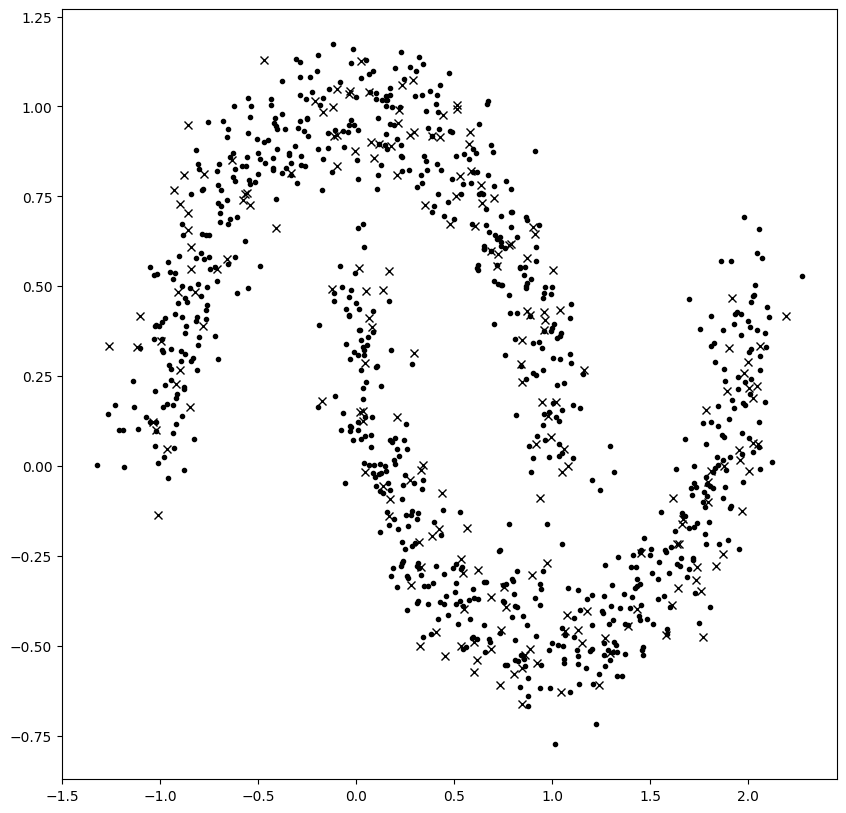

In [4]:
# Visualize the data
from matplotlib.pyplot import figure
fig = figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.plot(x_train[:,0],x_train[:,1],"k.")
ax.plot(x_valid[:,0],x_valid[:,1],"kx")

### Encode targets and move to pytorch

In [18]:
import torch
x_train_tensor,y_train_tensor = torch.tensor(x_train), torch.tensor(y_train)
x_valid_tnsr, y_valid_tnsr = torch.tensor(x_valid), torch.tensor(y_valid)
print(y_train_tensor[:10])
y_train_tensor = torch.nn.functional.one_hot(y_train_tensor, num_classes=2)
y_valid_tnsr = torch.nn.functional.one_hot(y_valid_tnsr, num_classes=2)
print(y_train_tensor[:10])


tensor([1, 1, 0, 0, 0, 1, 1, 1, 0, 1])
tensor([[0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 1]])


In [19]:
import torch

# Create an input tensor of integer labels
labels = torch.tensor([1, 0, 3, 2, 1, 2, 0, 3])

# Convert the integer labels to one-hot vectors
num_classes = 4
one_hot = torch.nn.functional.one_hot(labels, num_classes)

print(one_hot)
torch.arange(0, 6) % 3


tensor([[0, 1, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [1, 0, 0, 0],
        [0, 0, 0, 1]])


tensor([0, 1, 2, 0, 1, 2])

In [20]:
torch.manual_seed(5)
w = torch.randn(size = (2,2))
w.requires_grad = True
w = w.to(torch.float64)
w.retain_grad()
print(w.shape) # To make sure we didn't mess something up TOT
print(bool(w.retain_grad))



b = torch.randn(size = (1,2))
b.requires_grad = True
b = b.to(torch.float64)
b.retain_grad()


torch.Size([2, 2])
True


In [21]:
def predict(x):
    a = x.to(torch.float64) @ w.t() + b
    return torch.softmax(a, dim =1)

In [22]:
y_hat = predict(torch.tensor([[1,1],[2,2]])) # x should be 1x2
y_hat

tensor([[0.0342, 0.9658],
        [0.0106, 0.9894]], dtype=torch.float64, grad_fn=<SoftmaxBackward0>)

In [23]:
def loss_fn(x,y):
    y_hat = predict(x)
    return torch.mean(-(y*torch.log(y_hat)).sum(dim=1))
# want to make sure it returns one scalar
l = loss_fn(x=torch.tensor([[1,1],[2,2]]), y=torch.tensor([[0,1],[1,0]]))
l

tensor(2.2928, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [26]:
# optmization loop
DELTA = 0.1
EPOCHS = 1000
train_loss, valid_loss = [],[]
for _ in range(EPOCHS):
    curr_train_loss = loss_fn(x_train_tensor, y_train_tensor) 
    #befor the backward probagation, zero it
    
    curr_train_loss.backward()

    train_loss.append(curr_train_loss.data)
    with torch.no_grad():
        curr_valid_loss = loss_fn(x_valid_tnsr,y_valid_tnsr)
        valid_loss.append(curr_valid_loss.data)
        w -= DELTA * w.grad.data
        b -= DELTA * b.grad.data
        w.grad.zero_()
        b.grad.zero_()
    

In [27]:
help(torch.no_grad())

Help on no_grad in module torch.autograd.grad_mode object:

class no_grad(torch.utils._contextlib._NoParamDecoratorContextManager)
 |  no_grad() -> None
 |  
 |  Context-manager that disables gradient calculation.
 |  
 |  Disabling gradient calculation is useful for inference, when you are sure
 |  that you will not call :meth:`Tensor.backward()`. It will reduce memory
 |  consumption for computations that would otherwise have `requires_grad=True`.
 |  
 |  In this mode, the result of every computation will have
 |  `requires_grad=False`, even when the inputs have `requires_grad=True`.
 |  There is an exception! All factory functions, or functions that create
 |  a new Tensor and take a requires_grad kwarg, will NOT be affected by
 |  this mode.
 |  
 |  This context manager is thread local; it will not affect computation
 |  in other threads.
 |  
 |  Also functions as a decorator.
 |  
 |  .. note::
 |      No-grad is one of several mechanisms that can enable or
 |      disable grad

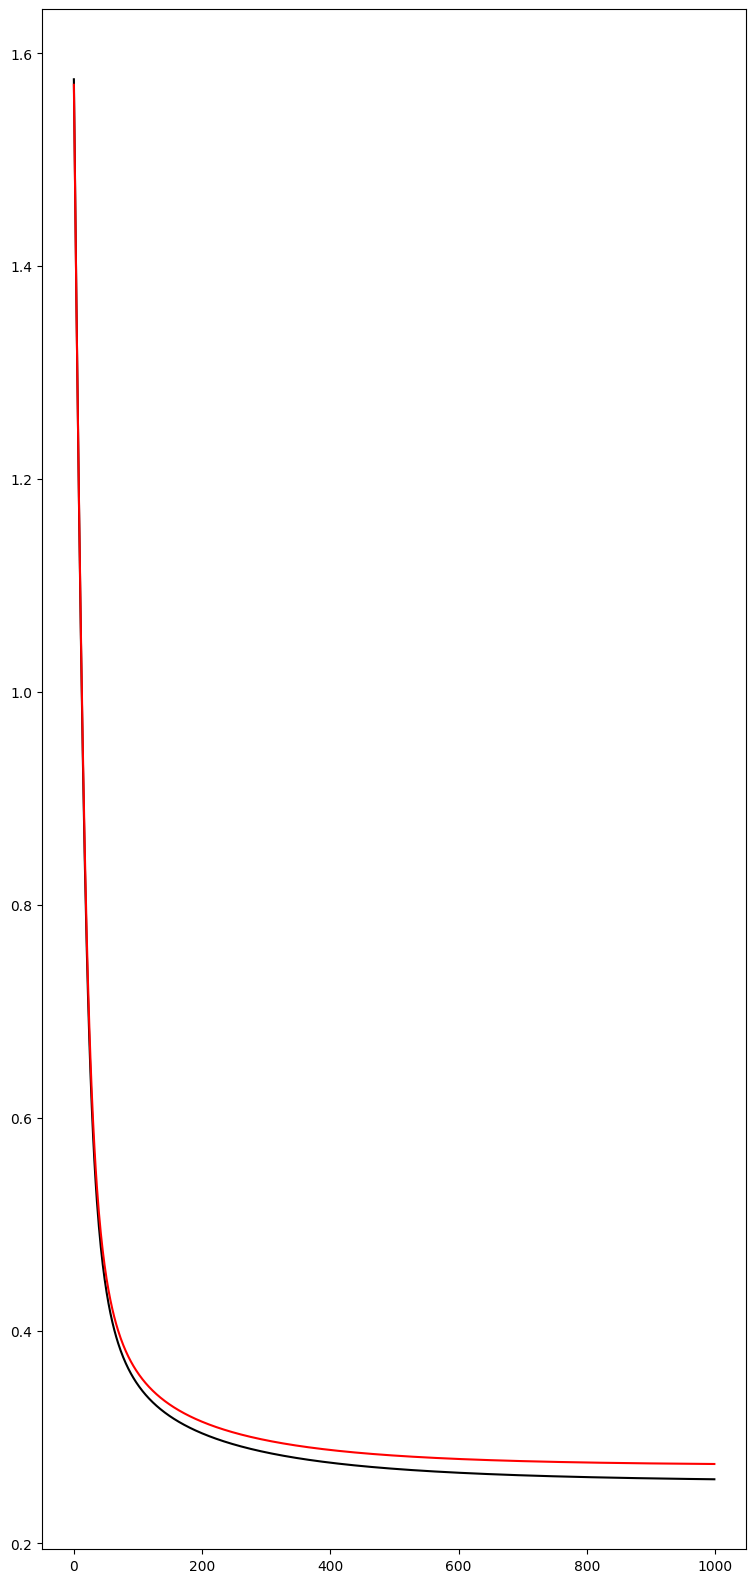

In [ ]:
#visualization of the loss function
from matplotlib.pyplot import figure
fig = figure(figsize = (20,20))
ax = fig.add_subplot(1,2,1)
ax.plot(train_loss, 'k')
ax.plot(valid_loss, 'r')

C:\Users\nouran\AppData\Local\Temp\ipykernel_13612\3740676271.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


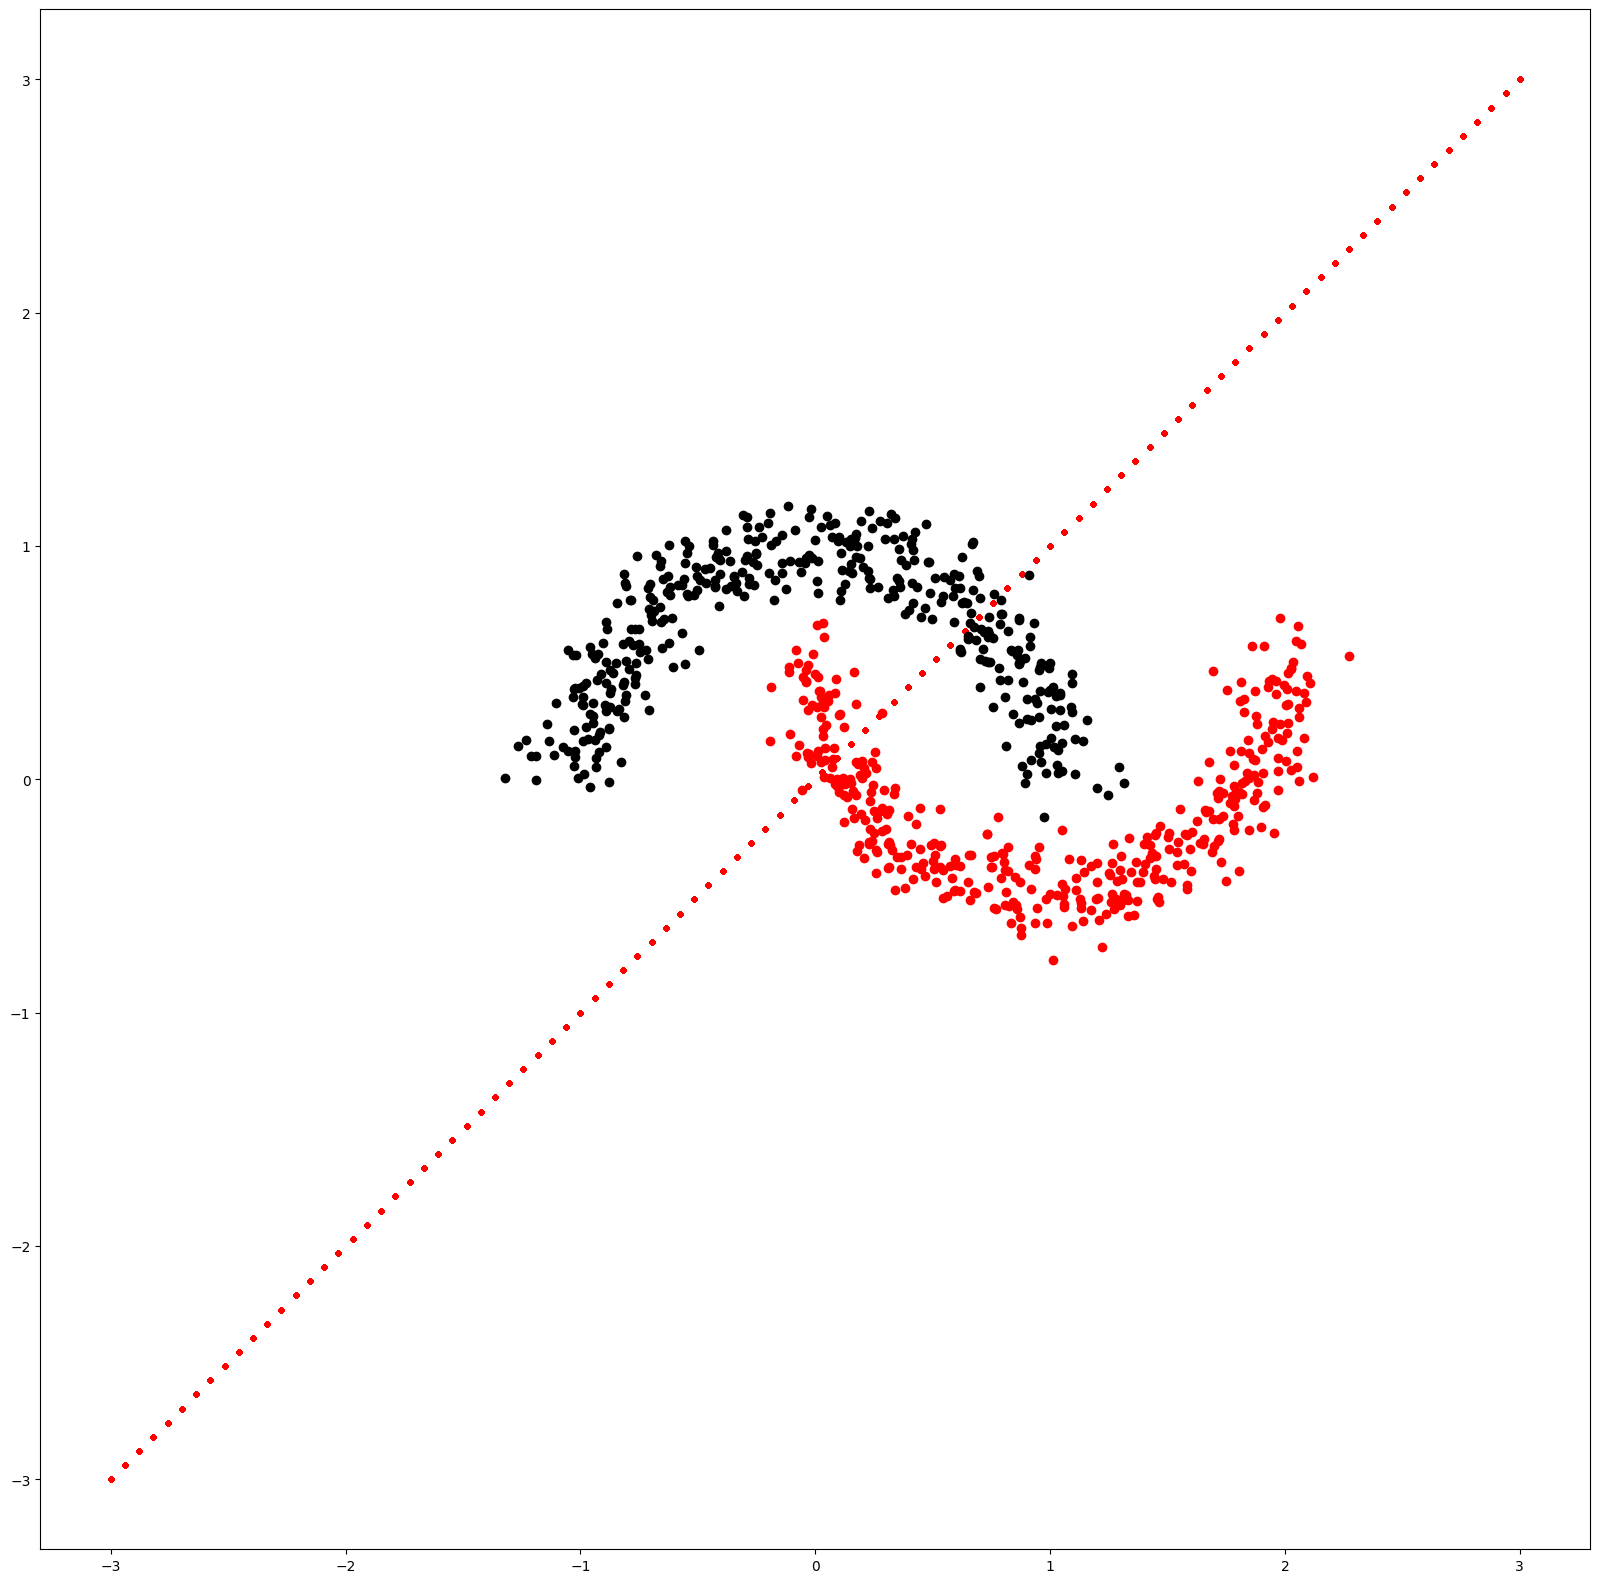

In [32]:
import numpy as np
from matplotlib.pyplot import figure
with torch.no_grad():
    x_0 = torch.linspace(-3,3,100).repeat(1,100).t()
    x_1 = torch.linspace(-3,3,100).repeat(1,100).t()
    x = torch.hstack((x_0,x_1)).to(torch.double)
    x_plt = x.numpy()
    y_hat = predict(x)
    c_hat = torch.argmax(y_hat, dim =1)
    c_hat_plt = c_hat.numpy()

fig = figure(figsize=(20,20))
ax = fig.add_subplot(1,1,1)
# The red line representing the predictions
ax.plot(x_plt[np.argwhere(c_hat_plt==1),0], x_plt[np.argwhere(c_hat_plt==1),1], "r.") 
ax.plot(x_plt[np.argwhere(c_hat_plt==0),0], x_plt[np.argwhere(c_hat_plt==0),1], "r.")
# The dataset
train_zero_indices = np.argwhere(y_train == 0)
train_one_indices = np.argwhere(y_train == 1)
valid_zero_indices = np.argwhere(y_valid == 0)
valid_one_indices = np.argwhere(y_valid == 1)
ax.plot(x_train[train_zero_indices, 0], x_train[train_zero_indices, 1], "ko")
ax.plot(x_train[train_one_indices, 0], x_train[train_one_indices, 1], "ro")
fig.show()

